In [1]:
from pyspark.sql import SparkSession

# Initialize a Spark session with 2 local workers
spark = SparkSession.builder \
    .master("local[2]") \
    .appName("Book Impact Prediction") \
    .getOrCreate()


23/12/30 13:48:36 WARN Utils: Your hostname, Apples-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.149 instead (on interface en0)
23/12/30 13:48:36 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/30 13:48:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/12/30 13:48:37 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [56]:
# Load the dataset
file_path = './books_task.csv'  
df = spark.read.csv(file_path,
    header=True,
    inferSchema=True,  # Set to 'true' to infer schema, 'false' to use the defined schema
    ignoreLeadingWhiteSpace=True,
    ignoreTrailingWhiteSpace=True,
    multiLine=True,  # Use if values contain newline characters
    quote='"',  # Adjust if your data uses a different quote character
    escape='"'  # Adjust if your data uses an escape character)
)

In [57]:
# Display the first few rows of the DataFrame
df.show(5)

# Print the schema of the DataFrame
df.printSchema()

# Summary statistics for numerical columns
df.describe().show()

# Count the number of rows in the DataFrame
print("Total number of rows in the dataset:", df.count())


23/12/30 14:21:41 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Title, description, authors, publisher, publishedDate, categories, Impact
 Schema: _c0, Title, description, authors, publisher, publishedDate, categories, Impact
Expected: _c0 but found: 
CSV file: file:///Users/apple/Book-Impact/books_task.csv
23/12/30 14:21:41 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Title, description, authors, publisher, publishedDate, categories, Impact
 Schema: _c0, Title, description, authors, publisher, publishedDate, categories, Impact
Expected: _c0 but found: 
CSV file: file:///Users/apple/Book-Impact/books_task.csv


+---+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-----------------+
|_c0|               Title|         description|             authors|           publisher|publishedDate|          categories|           Impact|
+---+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-----------------+
|  0|Its Only Art If I...|                NULL|    ['Julie Strain']|Smithsonian Insti...|         1996|['Comics & Graphi...|784.3039243054303|
|  1|Dr. Seuss: Americ...|Philip Nel takes ...|      ['Philip Nel']|           A&C Black|   2005-01-01|['Biography & Aut...|825.4655354138016|
|  2|Wonderful Worship...|This resource inc...|    ['David R. Ray']|             OUP USA|         2000|        ['Religion']|841.7053210126119|
|  3|Whispers of the W...|Julia Thomas find...| ['Veronica Haddon']|           iUniverse|      2005-02|         ['Fiction']|666.4265418233589|

+-------+------------------+--------------------+--------------------+-------------------+--------------------+------------------+--------------------+-----------------+
|summary|               _c0|               Title|         description|            authors|           publisher|     publishedDate|          categories|           Impact|
+-------+------------------+--------------------+--------------------+-------------------+--------------------+------------------+--------------------+-----------------+
|  count|            138724|              138724|              125975|             136001|              138724|            138376|              138724|           138724|
|   mean|103639.46568726392|  1247.5555555555557|  1.4285714285714286|               NULL|             51495.0|1993.4554169957207|                NULL| 786.763661968161|
| stddev| 61169.08229994296|   817.2282592873167|  0.9759000729485332|               NULL|                NULL|  20.5807728797189|                NULL

Total number of rows in the dataset: 138724


In [58]:
# convert publisheddate to year to bring data in consistent format
import re
from pyspark.sql.functions import udf
import pyspark.sql.functions  as F
from pyspark.sql.types import IntegerType

def extract_year(date_str):
    if not date_str:
        return None
    # Check for the format yyyy-mm or yyyy
    match = re.match(r'^(\d{4})', date_str)
    if match:
        return int(match.group(1))
    # Check for the format dd/mm/yyyy
    match = re.match(r'\d{2}/\d{2}/(\d{4})', date_str)
    if match:
        return int(match.group(1))
    # Return None if no known format is matched
    return None

extract_year_udf = udf(extract_year, IntegerType())

df = df.withColumn("publish_year", extract_year_udf(df["publishedDate"]))
df.select("publishedDate", "publish_year").show()


+-------------+------------+
|publishedDate|publish_year|
+-------------+------------+
|         1996|        1996|
|   2005-01-01|        2005|
|         2000|        2000|
|      2005-02|        2005|
|         1996|        1996|
|   2009-01-01|        2009|
|         1995|        1995|
|   1994-02-17|        1994|
|      2005-07|        2005|
|   2018-11-06|        2018|
|   2012-12-06|        2012|
|   2018-02-27|        2018|
|   2010-01-28|        2010|
|   2016-01-05|        2016|
|   2012-02-01|        2012|
|         1976|        1976|
|   2011-07-27|        2011|
|   2015-06-15|        2015|
|   2000-04-26|        2000|
|   2020-08-06|        2020|
+-------------+------------+
only showing top 20 rows



In [59]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
import re

def process_categories(cat_str):
    # Check if the string is correctly formatted (enclosed in brackets)
    if cat_str and re.match(r'^\[.*\]$', cat_str):
        # Remove brackets and split by comma
        return cat_str.strip("[]").split(", ")
    else:
        # Return None if format is incorrect
        return None

process_categories_udf = udf(process_categories, ArrayType(StringType()))



In [60]:
df = df.withColumn("processed_categories", process_categories_udf(df["categories"]))

from pyspark.sql.functions import explode

# Explode the 'processed_categories' array to individual rows
exploded_df = df.withColumn("category", explode("processed_categories"))

# Filter out None values
exploded_df = exploded_df.filter(exploded_df["category"].isNotNull())

# Count the number of books in each category
category_distribution = exploded_df.groupBy("category").count()

# Sort the distribution
sorted_distribution = category_distribution.orderBy("count", ascending=False)

# Show the sorted distribution of books across categories
sorted_distribution.show(100)


+--------------------+-----+
|            category|count|
+--------------------+-----+
|           'Fiction'|23419|
|          'Religion'| 9459|
|           'History'| 9330|
|  'Juvenile Fiction'| 6643|
|'Biography & Auto...| 6324|
|'Business & Econo...| 5625|
|         'Computers'| 4312|
|    'Social Science'| 3834|
|'Juvenile Nonfict...| 3446|
|           'Science'| 2623|
|         'Education'| 2611|
|           'Cooking'| 2445|
|'Sports & Recreat...| 2267|
|'Family & Relatio...| 2178|
|'Literary Criticism'| 2147|
|             'Music'| 2106|
|           'Medical'| 2079|
|               'Art'| 2054|
|               'Body| 2049|
|      Mind & Spirit'| 2049|
|'Language Arts & ...| 2036|
|  'Health & Fitness'| 2030|
| 'Political Science'| 1955|
|        'Psychology'| 1913|
|        'Philosophy'| 1864|
|            'Travel'| 1812|
|'Technology & Eng...| 1662|
|         'Self-Help'| 1519|
|            'Poetry'| 1500|
|'Foreign Language...| 1404|
|  'Crafts & Hobbies'| 1350|
|   'Performin

In [61]:
# Count the number of categories for each book
df = df.withColumn("category_count", F.size("processed_categories"))

# Filter out books with more than one category
multi_category_books = df.filter(df["category_count"] >=1)

# Group by the number of categories and count the books
category_count_distribution = multi_category_books.groupBy("category_count").count()

# Sort the distribution
sorted_category_count_distribution = category_count_distribution.orderBy("category_count")

# Show the distribution of the number of books with multiple categories
sorted_category_count_distribution.show()

+--------------+------+
|category_count| count|
+--------------+------+
|             1|136205|
|             2|  2421|
|             3|    98|
+--------------+------+



In [68]:
df.describe().show()

23/12/30 14:27:40 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Title, description, authors, publisher, publishedDate, categories, Impact
 Schema: _c0, Title, description, authors, publisher, publishedDate, categories, Impact
Expected: _c0 but found: 
CSV file: file:///Users/apple/Book-Impact/books_task.csv


+-------+------------------+--------------------+--------------------+-------------------+--------------------+------------------+--------------------+-----------------+------------------+-------------------+
|summary|               _c0|               Title|         description|            authors|           publisher|     publishedDate|          categories|           Impact|      publish_year|     category_count|
+-------+------------------+--------------------+--------------------+-------------------+--------------------+------------------+--------------------+-----------------+------------------+-------------------+
|  count|            138724|              138724|              125975|             136001|              138724|            138376|              138724|           138724|            138347|             138724|
|   mean|103639.46568726392|  1247.5555555555557|  1.4285714285714286|               NULL|             51495.0|1993.4554169957207|                NULL| 786.76366196

In [86]:
import re
from pyspark.sql.functions import udf, explode, col, count, size
from pyspark.sql.types import ArrayType, StringType

def process_authors(author_str):
    if author_str and re.match(r"^\[.*\]$", author_str):
        # Extract authors within single or double quotes
        authors = re.findall(r"\"(.*?)\"|\'(.*?)\'", author_str)
        # Flatten the tuple results and filter out None values
        processed_authors = [name for t in authors for name in t if name]
        return processed_authors if processed_authors else None
    else:
        return None

process_authors_udf = udf(process_authors, ArrayType(StringType()))

# Apply the UDF to process the `authors` column
df = df.withColumn("processed_authors", process_authors_udf(col("authors")))


In [87]:
df.select("authors", "processed_authors").show()


+--------------------+--------------------+
|             authors|   processed_authors|
+--------------------+--------------------+
|    ['Julie Strain']|      [Julie Strain]|
|      ['Philip Nel']|        [Philip Nel]|
|    ['David R. Ray']|      [David R. Ray]|
| ['Veronica Haddon']|   [Veronica Haddon]|
|['Everett Ferguson']|  [Everett Ferguson]|
|['Mary Fabyan Win...|[Mary Fabyan Wind...|
|  ['Steven Wardell']|    [Steven Wardell]|
|['Camillia Fawzi ...|[Camillia Fawzi E...|
|['Armando Salda A...|[Armando Salda A-...|
|['Evelyn B. Chris...|[Evelyn B. Christ...|
|['Allen Gersho', ...|[Allen Gersho, Ro...|
|      ['Frank Owen']|        [Frank Owen]|
|    ['Fiona Cownie']|      [Fiona Cownie]|
|['Rochelle Gurste...| [Rochelle Gurstein]|
|['Kenneth H. Coop...| [Kenneth H. Cooper]|
|     ['Ruth Allman']|       [Ruth Allman]|
|     ['Robert Kane']|       [Robert Kane]|
|['Dorling Kinders...|[Dorling Kindersl...|
|     ['Howard Hill']|       [Howard Hill]|
|              ['DK']|          

In [91]:
# Explode the authors array into individual rows
exploded_df = df.withColumn("individual_author", explode(col("processed_authors")))

# Group by individual authors and count the number of books
author_distribution = exploded_df.groupBy("individual_author").count()

# Order by the count and show top authors
top_authors = author_distribution.orderBy(col("count").desc()).show(500)

+--------------------+-----+
|   individual_author|count|
+--------------------+-----+
|           Rose Arny|  236|
|Library of Congre...|  164|
| William Shakespeare|  126|
|       Louis L'Amour|  110|
|     Agatha Christie|  103|
|             Various|   71|
|       Lonely Planet|   70|
|     Francine Pascal|   68|
|          Mark Twain|   65|
|Erle Stanley Gardner|   64|
|       Ann M. Martin|   62|
|     Rudyard Kipling|   62|
|Edgar Rice Burroughs|   61|
|       Carolyn Keene|   60|
|                  DK|   59|
|        Isaac Asimov|   56|
|        Nora Roberts|   56|
|      John Steinbeck|   55|
|     Charles Dickens|   52|
|        Stephen King|   50|
|         Jane Austen|   49|
|     Georgette Heyer|   48|
|         Henry James|   48|
|National Research...|   47|
|           Zane Grey|   46|
|       Lewis Carroll|   45|
|     Edgar Allan Poe|   45|
|        Andre Norton|   44|
|         C. S. Lewis|   44|
|         Oscar Wilde|   44|
|           Zondervan|   43|
|    Jerry B. 

In [92]:
# Count the number of authors for each book
df = df.withColumn("author_count", size(col("processed_authors")))

# Group by the number of authors and count the number of books
book_distribution_by_author_count = df.groupBy("author_count").count()

# Show the book distribution across the number of authors
book_distribution_by_author_count.orderBy("author_count").show()


+------------+------+
|author_count| count|
+------------+------+
|          -1|  2723|
|           1|107677|
|           2| 21169|
|           3|  5081|
|           4|  1307|
|           5|   402|
|           6|   153|
|           7|    73|
|           8|    39|
|           9|    27|
|          10|    13|
|          11|    11|
|          12|     6|
|          13|     5|
|          14|     3|
|          15|     3|
|          16|     3|
|          17|     3|
|          18|     1|
|          19|     3|
+------------+------+
only showing top 20 rows



In [98]:
df.describe("Impact").show()


+-------+-----------------+
|summary|           Impact|
+-------+-----------------+
|  count|           138724|
|   mean| 786.763661968161|
| stddev|63.64035032297846|
|    min|              0.0|
|    max|           1000.0|
+-------+-----------------+



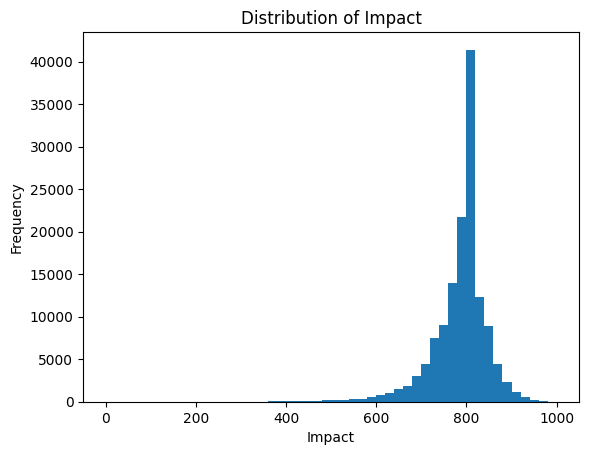

In [101]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'Impact' column to Pandas DataFrame
impact_pd = df.select("Impact").toPandas()

# Plotting the histogram
plt.hist(impact_pd['Impact'], bins=50)
plt.title('Distribution of Impact')
plt.xlabel('Impact')
plt.ylabel('Frequency')
plt.show()

In [102]:
percentiles = [i / 10 for i in range(11)]

# Calculate percentiles
impact_percentiles = df.stat.approxQuantile("Impact", percentiles, 0)
percentile_values = {f"{int(p*100)}th percentile": val for p, val in zip(percentiles, impact_percentiles)}

for percentile, value in percentile_values.items():
    print(f"{percentile}: {value}")


0th percentile: 0.0
10th percentile: 718.3813652211307
20th percentile: 755.9182978039748
30th percentile: 776.2309491765689
40th percentile: 784.3039243054303
50th percentile: 805.5685400829483
60th percentile: 805.5685400829483
70th percentile: 812.2857832807687
80th percentile: 823.9607318560921
90th percentile: 845.4664825825195
100th percentile: 1000.0



# Feature Engineering

We start with creating one hot vectors for authors and categories where we will limit it to top 100 authors else the vectors would be very large and sparse

In [105]:
# Explode the processed_categories and processed_authors into individual rows
cat_exploded = df.withColumn("category", explode(col("processed_categories")))
author_exploded = df.withColumn("author", explode(col("processed_authors")))

# Find the most frequent categories and authors
top_categories = cat_exploded.groupBy("category").count().orderBy(col("count").desc()).limit(100)  # Top 100 categories
top_authors = author_exploded.groupBy("author").count().orderBy(col("count").desc()).limit(100)  # Top 100 authors

# Get lists of top categories and authors
top_cat_list = [row.category for row in top_categories.collect()]
top_author_list = [row.author for row in top_authors.collect()]

# Filter the exploded DataFrames
filtered_cat = cat_exploded.filter(cat_exploded.category.isin(top_cat_list))
filtered_author = author_exploded.filter(author_exploded.author.isin(top_author_list))


In [117]:

from pyspark.sql.functions import array_contains

# Explode the categories and authors
df_categories = df.withColumn("category", explode(col("processed_categories")))
df_authors = df.withColumn("author", explode(col("processed_authors")))

# Find top 100 categories and authors
top_categories = df_categories.groupBy("category").count().orderBy(col("count").desc()).limit(100).rdd.map(lambda row: row[0]).collect()
top_authors = df_authors.groupBy("author").count().orderBy(col("count").desc()).limit(100).rdd.map(lambda row: row[0]).collect()

def filter_top_entities(arr, top_entities):
    # Check if the array is None
    if arr is None:
        return None  # or return ['Other'] if you prefer to treat None as 'Other'
    else:
        return [x if x in top_entities else 'Other' for x in arr]


filter_udf = udf(filter_top_entities, ArrayType(StringType()))

df = df.withColumn("filtered_categories", filter_udf(col("processed_categories"), F.array([F.lit(x) for x in top_categories])))
df = df.withColumn("filtered_authors", filter_udf(col("processed_authors"), F.array([F.lit(x) for x in top_authors])))

for category in top_categories:
    df = df.withColumn(f"cat_{category}", array_contains(col("filtered_categories"), category).cast("integer"))

for author in top_authors:
    df = df.withColumn(f"auth_{author}", array_contains(col("filtered_authors"), author).cast("integer"))

# Show the result
df.show()


+---+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-----------------+------------+--------------------+--------------+--------------------+------------+--------------------+--------------------+-------------+--------------+-------------+----------------------+-------------------------------+--------------------------+---------------+--------------------+-------------------------+-------------+---------------+-------------+-------------------------+----------------------------+------------------------+-----------+-------------+---------+---------+------------------+---------------------------------+----------------------+-----------------------+----------------+----------------+------------+------------------------------+---------------+------------+----------------------------+----------------------+---------------------+---------------+-----------------+-----------------------------+------------+-----------------

23/12/30 19:35:04 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Title, description, authors, publisher, publishedDate, categories, Impact
 Schema: _c0, Title, description, authors, publisher, publishedDate, categories, Impact
Expected: _c0 but found: 
CSV file: file:///Users/apple/Book-Impact/books_task.csv


In [115]:
# Aggregate back to original row format
final_df = df_transformed.groupBy("book_id").agg(collect_list("categoryVec").alias("category_features"), collect_list("authorVec").alias("author_features"))

final_df.show(truncate=False)



23/12/30 19:27:35 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Title, description, authors, publisher, publishedDate, categories, Impact
 Schema: _c0, Title, description, authors, publisher, publishedDate, categories, Impact
Expected: _c0 but found: 
CSV file: file:///Users/apple/Book-Impact/books_task.csv


+---+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-----------------+------------+--------------------+--------------+--------------------+------------+--------------------+--------------------+--------------------+------+-------------+----------------+-----------+---------------+
|_c0|               Title|         description|             authors|           publisher|publishedDate|          categories|           Impact|publish_year|processed_categories|category_count|   processed_authors|author_count| filtered_categories|    filtered_authors|            category|author|categoryIndex|     categoryVec|authorIndex|      authorVec|
+---+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-----------------+------------+--------------------+--------------+--------------------+------------+--------------------+--------------------+--------------------+--

In [118]:
# Using Ordinal Encoding for Publisher instead of 1 hot since it can be large

# Count the number of unique publishers
unique_publishers_count = df.select("publisher").distinct().count()

print(f"Number of unique publishers: {unique_publishers_count}")

Number of unique publishers: 12851


In [121]:
publisher_distribution = df.groupBy("publisher").count().orderBy("count", ascending=False)

# Show the distribution
publisher_distribution.show(100)

+--------------------+-----+
|           publisher|count|
+--------------------+-----+
|     Tan Books & Pub| 3635|
|  Simon and Schuster| 3600|
|Smithsonian Insti...| 3216|
|             Penguin| 2788|
|Wm. B. Eerdmans P...| 2563|
|           Routledge| 2371|
|   John Wiley & Sons| 1984|
|      Harper Collins| 1959|
|Cambridge Univers...| 1478|
|           A&C Black| 1355|
|           Macmillan| 1215|
|             OUP USA| 1187|
|    Berg Pub Limited| 1169|
| Courier Corporation| 1116|
|           iUniverse| 1057|
|Bloomsbury Publis...| 1031|
|     Open Road Media|  983|
|             Vintage|  976|
|Springer Science ...|  885|
|Houghton Mifflin ...|  878|
|Oxford University...|  759|
|        Random House|  751|
|         Hachette UK|  724|
|Princeton Univers...|  619|
|Oxford University...|  604|
|Cumberland House ...|  590|
|W. W. Norton & Co...|  573|
|Univ of Californi...|  560|
|           Harlequin|  555|
|McGraw Hill Profe...|  548|
|       HarperCollins|  539|
|           CR

In [122]:
# String Indexer for publisher
publisher_indexer = StringIndexer(inputCol="publisher", outputCol="publisherIndex")

# Pipeline for transformation
pipeline = Pipeline(stages=[publisher_indexer])

# Fit and transform
df_transformed = pipeline.fit(df).transform(df)

In [124]:
df = df_transformed
# Calculate the 1st and 99th percentiles for publish_year
bounds = df.approxQuantile("publish_year", [0.01, 0.99], 0)
lower_bound, upper_bound = bounds

# Filter out rows where publish_year is outside the 1st and 99th percentiles
df_filtered = df.filter((col("publish_year") >= lower_bound) & (col("publish_year") <= upper_bound))

# Show the result or perform further operations
df_filtered.show()

23/12/30 19:52:47 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Title, description, authors, publisher, publishedDate, categories, Impact
 Schema: _c0, Title, description, authors, publisher, publishedDate, categories, Impact
Expected: _c0 but found: 
CSV file: file:///Users/apple/Book-Impact/books_task.csv


+---+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-----------------+------------+--------------------+--------------+--------------------+------------+--------------------+--------------------+-------------+--------------+-------------+----------------------+-------------------------------+--------------------------+---------------+--------------------+-------------------------+-------------+---------------+-------------+-------------------------+----------------------------+------------------------+-----------+-------------+---------+---------+------------------+---------------------------------+----------------------+-----------------------+----------------+----------------+------------+------------------------------+---------------+------------+----------------------------+----------------------+---------------------+---------------+-----------------+-----------------------------+------------+-----------------

In [128]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml import Pipeline
df = df_filtered
df = df.fillna({'description': '', 'Title': ''})
# Tokenizer and StopWordsRemover for 'description'
tokenizer_desc = Tokenizer(inputCol="description", outputCol="description_tokens")
remover_desc = StopWordsRemover(inputCol="description_tokens", outputCol="description_filtered")

# Tokenizer and StopWordsRemover for 'title'
tokenizer_title = Tokenizer(inputCol="Title", outputCol="title_tokens")
remover_title = StopWordsRemover(inputCol="title_tokens", outputCol="title_filtered")

# HashingTF and IDF for 'description'
hashingTF_desc = HashingTF(inputCol="description_filtered", outputCol="description_rawFeatures", numFeatures=200)
idf_desc = IDF(inputCol="description_rawFeatures", outputCol="description_features")

# HashingTF and IDF for 'title'
hashingTF_title = HashingTF(inputCol="title_filtered", outputCol="title_rawFeatures", numFeatures=200)
idf_title = IDF(inputCol="title_rawFeatures", outputCol="title_features")

# Pipeline
pipeline = Pipeline(stages=[tokenizer_desc, remover_desc, hashingTF_desc, idf_desc, tokenizer_title, remover_title, hashingTF_title, idf_title])

# Fit the pipeline to the data
model = pipeline.fit(df)

# Transform the data
df_transformed = model.transform(df)

# Show the result or proceed with further operations
df_transformed.select("description_features", "title_features").show(truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
df